#참고<br>
https://github.com/zzsza/Play-Kaggle/blob/master/Predict-Future-Sales/notebook/01.%20EDA.ipynb

https://www.kaggle.com/c/competitive-data-science-predict-future-sales

https://zzsza.github.io/data/2018/09/08/feature-engineering/ # Feature Engineering

http://hero4earth.com/blog/learning/2018/01/29/Feature_Engineering_Basic/

Predict Future Sales

(File descriptions) <br>
sales_train.csv - the training set. Daily historical data from January 2013 to October 2015.<br>
test.csv - the test set. You need to forecast the sales for these shops and products for November 2015.<br>
sample_submission.csv - a sample submission file in the correct format.<br>
items.csv - supplemental information about the items/products.<br>
item_categories.csv  - supplemental information about the items categories.<br>
shops.csv- supplemental information about the shops.<br>

(Data fields)<br>
ID - an Id that represents a (Shop, Item) tuple within the test set<br>
shop_id - unique identifier of a shop<br>
item_id - unique identifier of a product<br>
item_category_id - unique identifier of item category<br>
item_cnt_day - number of products sold. You are predicting a monthly amount of this measure<br>
item_price - current price of an item<br>
date - date in format dd/mm/yyyy<br>
date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33<br>
item_name - name of item<br>
shop_name - name of shop<br>
item_category_name - name of item category<br>

In [1]:
import numpy as np
import pandas as pd
from pandas import Series
import matplotlib.pyplot as plt
import random
import seaborn as sns
import warnings

%matplotlib inline
warnings.filterwarnings("ignore")

데이터 읽어오기

In [2]:
item_category_df = pd.read_csv("item_categories.csv")
item_df = pd.read_csv("items.csv")
shop_df = pd.read_csv("shops.csv")
sample_df = pd.read_csv("sample_submission.csv")
train_df = pd.read_csv("sales_train_v2.csv")
test_df = pd.read_csv("test.csv")

# 데이터 탐색

In [3]:
print(item_category_df.shape)
print(item_df.shape)
print(shop_df.shape)
print(sample_df.shape)
print(train_df.shape)
print(test_df.shape)

(84, 2)
(22170, 3)
(60, 2)
(214200, 2)
(2935849, 6)
(214200, 3)


## 결측치확인

In [4]:
item_category_df.isnull().sum(axis=0)

item_category_name    0
item_category_id      0
dtype: int64

In [5]:
item_df.isnull().sum(axis=0)

item_name           0
item_id             0
item_category_id    0
dtype: int64

In [6]:
shop_df.isnull().sum(axis=0)

shop_name    0
shop_id      0
dtype: int64

In [7]:
sample_df.isnull().sum(axis=0)

ID                0
item_cnt_month    0
dtype: int64

In [8]:
train_df.isnull().sum(axis=0)

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

In [9]:
test_df.isnull().sum(axis=0)

ID         0
shop_id    0
item_id    0
dtype: int64

=> 연결 key가 되는 컬럼 <br>
  - item_category_id (item_category_df, items_df) <br>
  - item_id (item_df, train_df, test_df)<br>
  - shop_id (shop_df, train_df, test_df)<br>
  - ID (sample_df, test_df)<br>

In [4]:
train_all = pd.merge(train_df, item_df, how='left', on=['item_id','item_id'])
train_all = pd.merge(train_all, item_category_df, how='left', on=['item_category_id','item_category_id'])
train_all = pd.merge(train_all, shop_df, how='left', on=['shop_id','shop_id'])

In [5]:
train_all['date'] = pd.to_datetime(train_all['date'], format='%d.%m.%Y')
train_all['day'] = train_all['date'].dt.day
train_all['month'] = train_all['date'].dt.month
train_all['year'] = train_all['date'].dt.year

In [12]:
# item, item_category, shop의 name 컬럼 제거
# id 컬럼으로 대체 가능하다 판다, 러시아어 번역필요 없음
#train_all = train_all.drop(['item_name', 'item_category_name', 'shop_name'], axis = 1) #탐색으로 잠시 off

In [13]:
print(train_all.shape)
train_all.head(3)

(2935849, 10)


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,day,month,year
0,2013-01-02,0,59,22154,999.0,1.0,37,2,1,2013
1,2013-01-03,0,25,2552,899.0,1.0,58,3,1,2013
2,2013-01-05,0,25,2552,899.0,-1.0,58,5,1,2013


## 관측치탐색 및 시각화

=> 시각화 아이디어<br>
   - date_block_num : 월별 판매 <br>
   - date : dd/mm/yy
   - item_cnt_day : 월간 금액 예측<br>
   - shop_id : 매장별 <br>
   - item_id : 상품별<br>
   - item_category_id : 카테고리별<br>

### 변수 탐색

In [6]:
train_all.columns

Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price',
       'item_cnt_day', 'item_name', 'item_category_id', 'item_category_name',
       'shop_name', 'day', 'month', 'year'],
      dtype='object')

히스토그램

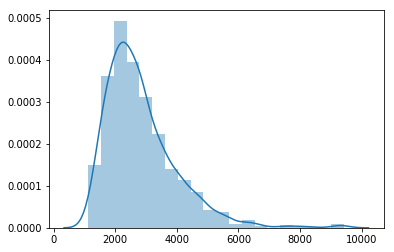

In [7]:
freq1 = train_all['date'].value_counts()
sns.distplot(freq1.values,bins=20)
plt.show()

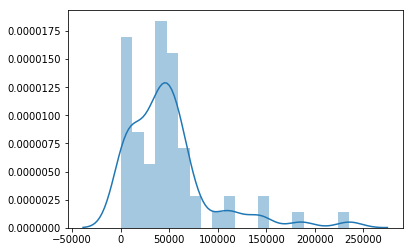

In [21]:
freq2 = train_all['shop_name'].value_counts()
sns.distplot(freq1.values,bins=20)
plt.show()

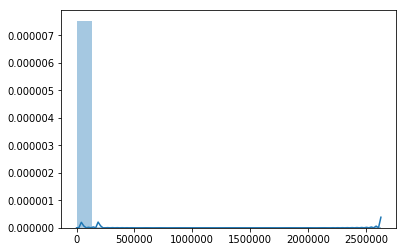

In [14]:
freq3 = train_all['item_cnt_day'].value_counts()
sns.distplot(freq1.values,bins=20)
plt.show()

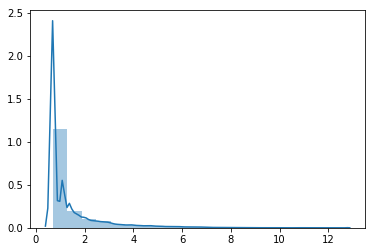

In [13]:
freq3b = np.log(freq1+1)
sns.distplot(freq1b.values,bins=20)
plt.show()

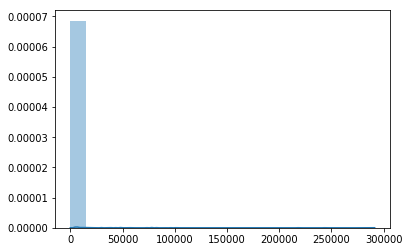

In [15]:
freq4 = train_all['item_price'].value_counts()
sns.distplot(freq1.values,bins=20)
plt.show()

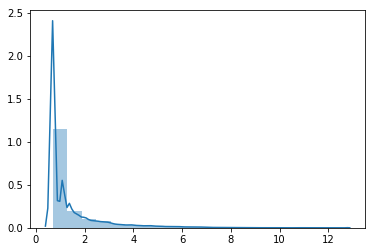

In [13]:
freq4b = np.log(freq1+1)
sns.distplot(freq1b.values,bins=20)
plt.show()

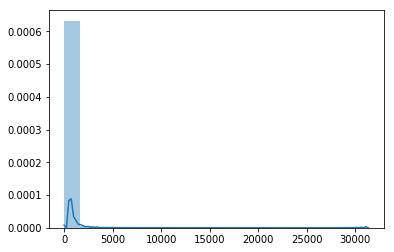

In [10]:
freq5 = train_all['item_id'].value_counts()
sns.distplot(freq1.values,bins=20)
plt.show()

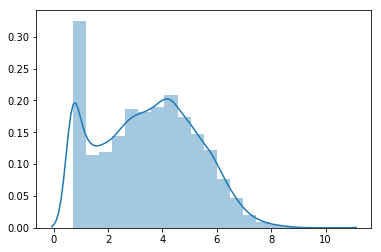

In [11]:
freq5b = np.log(freq1+1)
sns.distplot(freq1b.values,bins=20)
plt.show()

### groupby

In [14]:
group_month_mean = train_all.groupby(['month'], as_index=False)['item_cnt_day'].mean()
group_month_sum = train_all.groupby(['month'], as_index=False)['item_cnt_day'].sum()
group_DateBlockNum_mean = train_all.groupby(['date_block_num'], as_index=False)['item_cnt_day'].mean()
group_DateBlockNum_sum = train_all.groupby(['date_block_num'], as_index=False)['item_cnt_day'].sum()
group_category_mean = train_all.groupby(['item_category_id'], as_index=False)['item_cnt_day'].mean()
group_category_sum = train_all.groupby(['item_category_id'], as_index=False)['item_cnt_day'].sum()
group_shop_mean = train_all.groupby(['shop_id'], as_index=False)['item_cnt_day'].mean()
group_shop_sum = train_all.groupby(['shop_id'], as_index=False)['item_cnt_day'].sum()

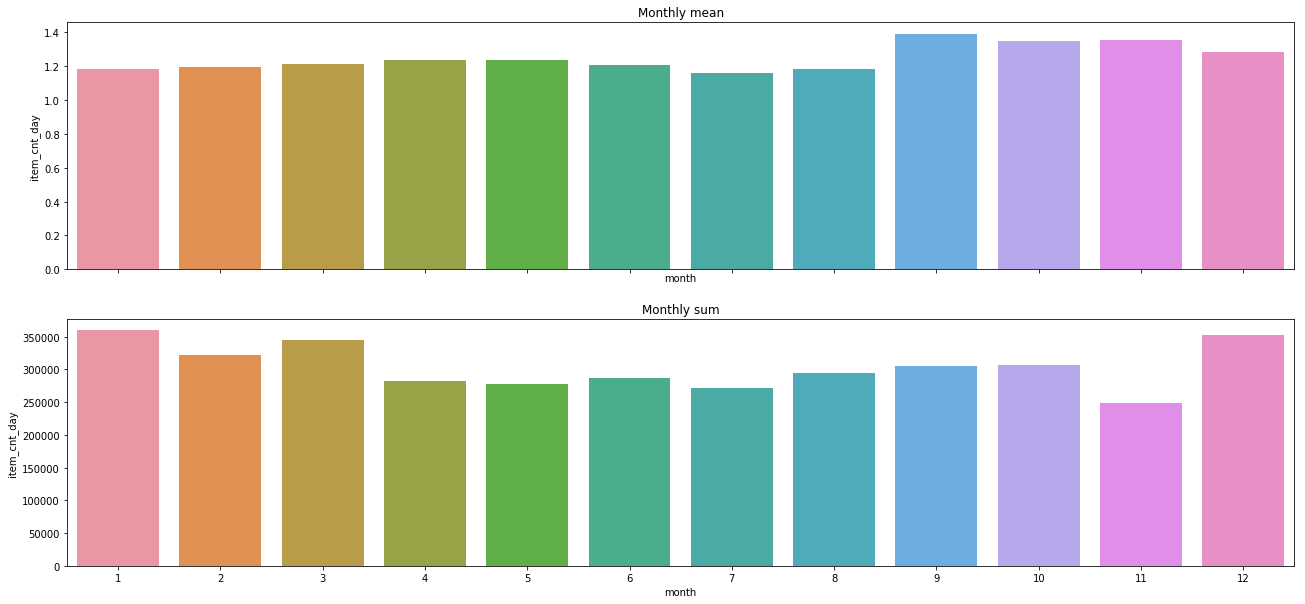

In [15]:
# 월별 매출 평균, 총 매출 확인
fig, axes = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
sns.barplot("month", "item_cnt_day", data=group_month_mean, ax=axes[0]).set_title("Monthly mean")
sns.barplot("month", "item_cnt_day", data=group_month_sum, ax=axes[1]).set_title("Monthly sum")
plt.show()

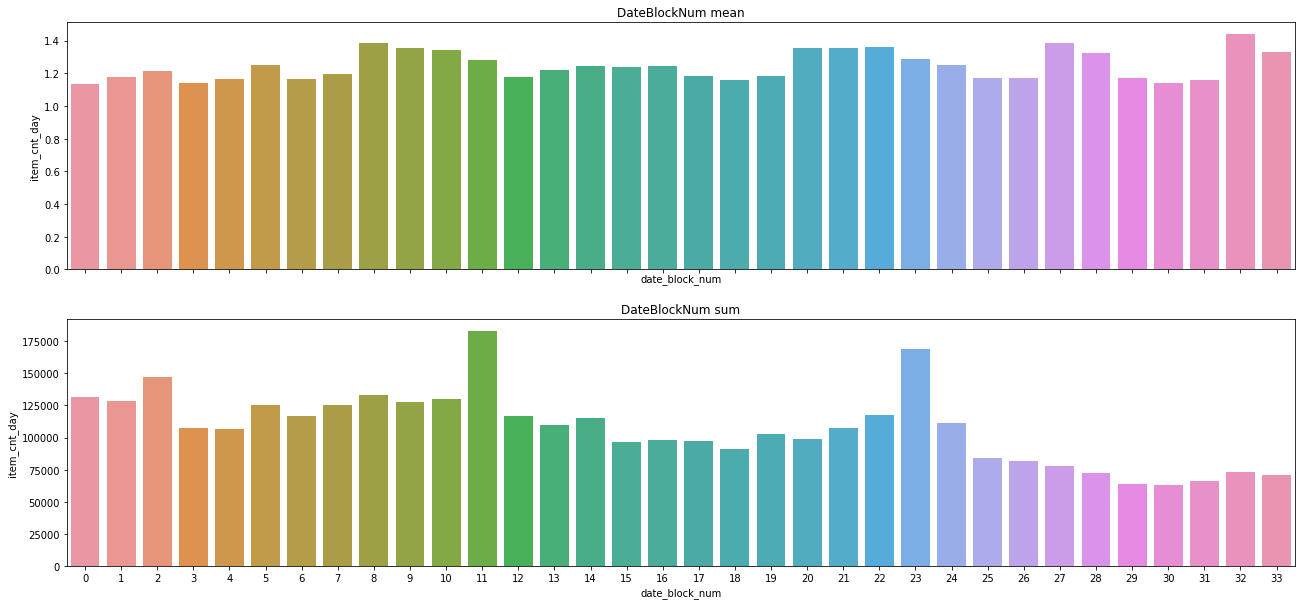

In [16]:
# 월별(년도별 월 분리, date_block_num) 매출 평균, 총 매출 확인
fig, axes = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
sns.barplot("date_block_num", "item_cnt_day", data=group_DateBlockNum_mean, ax=axes[0]).set_title("DateBlockNum mean")
sns.barplot("date_block_num", "item_cnt_day", data=group_DateBlockNum_sum, ax=axes[1]).set_title("DateBlockNum sum")
plt.show()

=>이슈<br>
:평균은 일정한 편인데 총합이 매년 줄어드는 것을 볼 수 있다.<br>
:여기서 도출해 낼 수 있는 해석은?

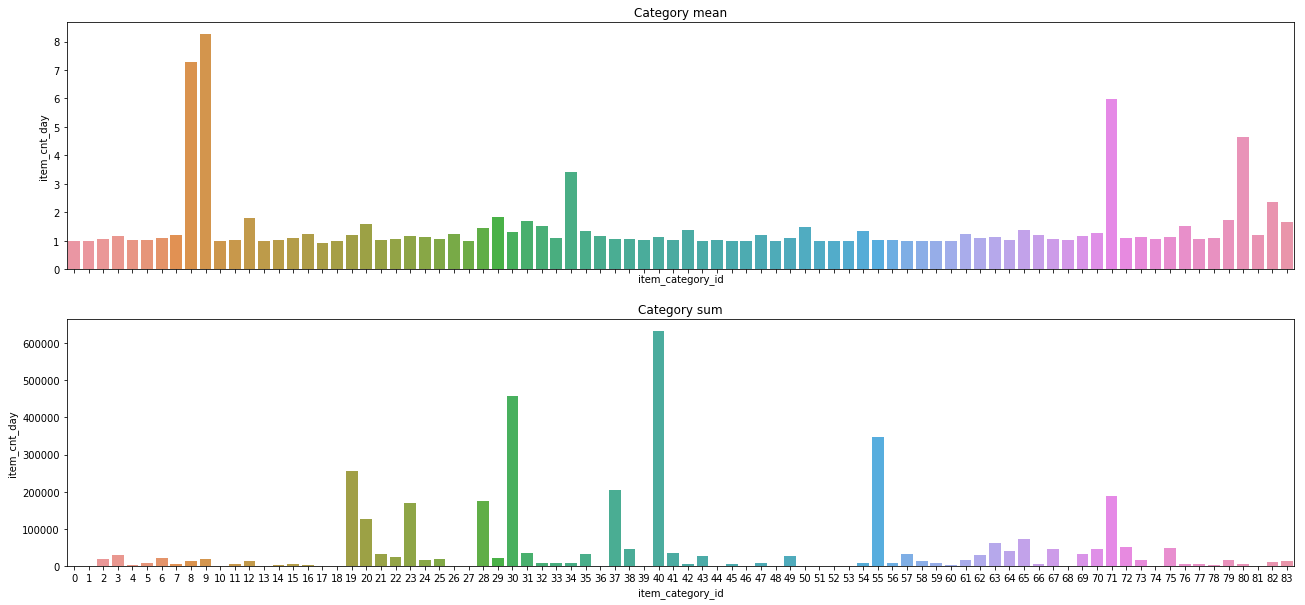

In [17]:
# 카테고리별 매출 평균, 총 매출 확인
fig, axes = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
sns.barplot("item_category_id", "item_cnt_day", data=group_category_mean, ax=axes[0]).set_title("Category mean")
sns.barplot("item_category_id", "item_cnt_day", data=group_category_sum, ax=axes[1]).set_title("Category sum")
plt.show()

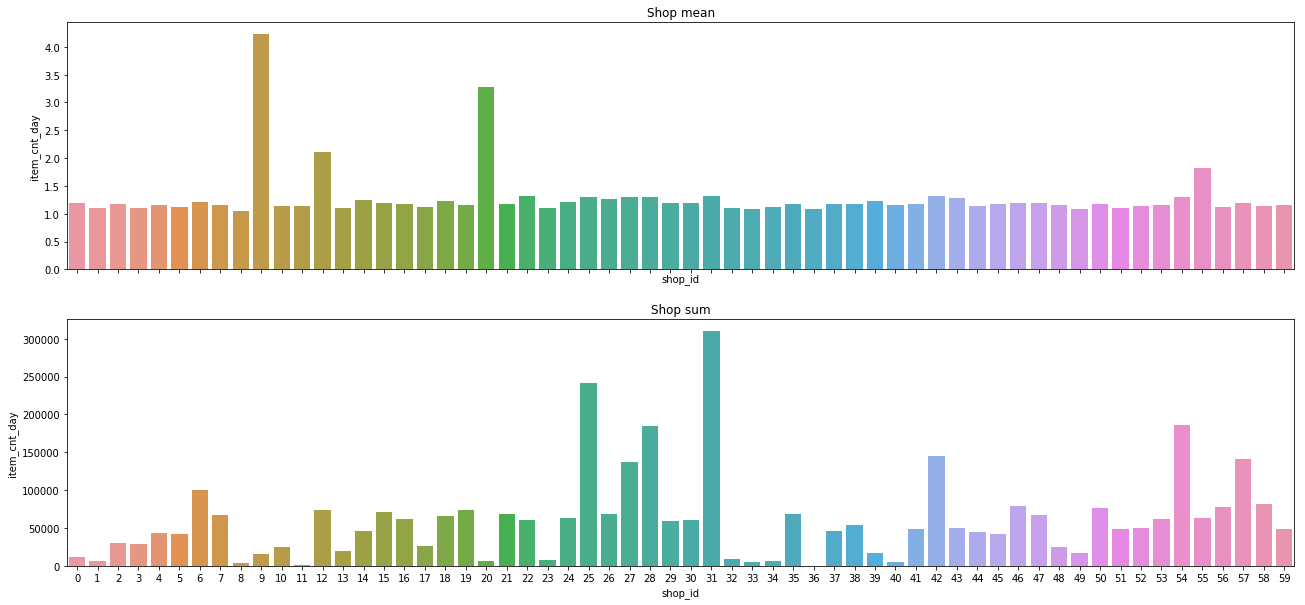

In [18]:
#가게별 평균매출과 총매출
fig, axes = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
sns.barplot("shop_id", "item_cnt_day", data=group_shop_mean, ax=axes[0]).set_title("Shop mean")
sns.barplot("shop_id", "item_cnt_day", data=group_shop_sum, ax=axes[1]).set_title("Shop sum")
plt.show()

### item_cnt_day 컬럼

In [19]:
group1 = train_all.drop(['date'],axis=1)

In [20]:
group1.groupby('item_cnt_day').count()

,date_block_num,shop_id,item_id,item_price,item_category_id,day,month,year
item_cnt_day,,,,,,,,
-22.0,1,1,1,1,1,1,1,1
-16.0,1,1,1,1,1,1,1,1
-9.0,1,1,1,1,1,1,1,1
-6.0,2,2,2,2,2,2,2,2
-5.0,4,4,4,4,4,4,4,4
-4.0,3,3,3,3,3,3,3,3
-3.0,14,14,14,14,14,14,14,14
-2.0,78,78,78,78,78,78,78,78
-1.0,7252,7252,7252,7252,7252,7252,7252,7252


In [21]:
# item_cnt_day가 -1인 것만 추출
check = train_all['item_cnt_day'] == -1
item_cnt_day_m1 = train_all[check==True]
item_cnt_day_m1.drop(['date','item_cnt_day'], axis = 1)

,date_block_num,shop_id,item_id,item_price,item_category_id,day,month,year
2,0,25,2552,899.00,58,5,1,2013
148,0,25,2321,999.00,28,23,1,2013
175,0,25,2199,1449.00,58,7,1,2013
807,0,25,2330,599.00,30,2,1,2013
1041,0,25,5034,1989.00,23,13,1,2013
1193,0,25,5651,5490.00,2,2,1,2013
1674,0,25,4093,899.00,58,7,1,2013
1825,0,25,4249,1894.87,23,2,1,2013
2411,0,24,1628,3899.00,59,14,1,2013
3216,0,24,20948,899.00,21,8,1,2013


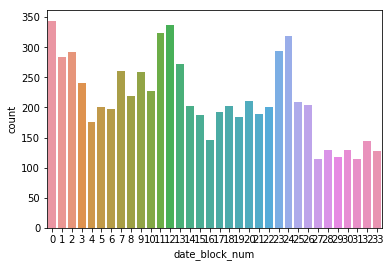

In [22]:
sns.countplot(item_cnt_day_m1.date_block_num)

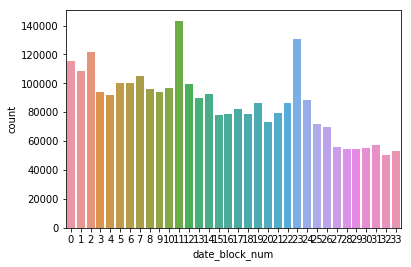

In [23]:
sns.countplot(train_all.date_block_num)

=> 이슈) 해석 <br>
:item_cnt_day 에서 ' - ' 값은 뭘까?<br>
==> 위 두 개의 countplot을 비교해서보면 11월과 12월이 다른 달과 차이가 있음을 볼 수 있고, 서칭해본 결과 러시아에 11월 마지막주에 블랙프라이데이가 있음을 확인. 그래서, -(마이너스)에 관한 관측치는 환불에 관한 데이터로 볼 수 있다고 해석<br>
그렇다면,
1. 판매예측이니까 환불데이터는 제외해야하나?
2. 따로 떼어 모델링하는게 의미가 있을까? <br>
==>  환불데이터.ipynb에서 자세히 볼 수 있지만 결론적으로 환불데이터 안에서 주기성은 찾지 못함, 즉 기본 가정인 단순 변심이나 제품의 불특정한 하자외에 다른 요인을 찾지 못함

### item_price 컬럼

In [24]:
group1.groupby('item_price').count()

,date_block_num,shop_id,item_id,item_cnt_day,item_category_id,day,month,year
item_price,,,,,,,,
-1.000000,1,1,1,1,1,1,1,1
0.070000,2,2,2,2,2,2,2,2
0.087500,1,1,1,1,1,1,1,1
0.090000,1,1,1,1,1,1,1,1
0.100000,2932,2932,2932,2932,2932,2932,2932,2932
0.200000,1,1,1,1,1,1,1,1
0.500000,1226,1226,1226,1226,1226,1226,1226,1226
0.908714,1,1,1,1,1,1,1,1
0.990000,493,493,493,493,493,493,493,493


=> 이슈)해석<br>
:item_price 에서 ' - ' 값은 뭘까<br>
==> 그 행은 지워도 될듯

In [25]:
# item_price가 -1인 관측치의 행 번호 추출
for i in range(train_all.shape[0]):
    if train_all['item_price'][i] == -1:
        print(f"{i}")
        break

484683


In [26]:
# item_price가 -1인 관측치의 item_id확인
train_all.loc[484683]

date                2013-05-15 00:00:00
date_block_num                        4
shop_id                              32
item_id                            2973
item_price                           -1
item_cnt_day                          1
item_category_id                     19
day                                  15
month                                 5
year                               2013
Name: 484683, dtype: object

In [27]:
# item_id가 2973인 상품의 총 개수 확인
# item_price가 -1인 상품이 하나인데 같은 상품인데 다른 가격인게 있는지 확인
check = train_all['item_id'] == 2973
item_id_2973 = train_all[check==True]
item_id_2973.drop(['date','item_id', 'item_category_id'], axis = 1)

,date_block_num,shop_id,item_price,item_cnt_day,day,month,year
352,0,25,2499.000000,13.0,15,1,2013
353,0,25,2499.000000,5.0,16,1,2013
354,0,25,2499.000000,3.0,17,1,2013
355,0,25,2499.000000,2.0,18,1,2013
356,0,25,2499.000000,3.0,19,1,2013
357,0,25,2499.000000,1.0,20,1,2013
358,0,25,2499.000000,1.0,21,1,2013
359,0,25,2499.000000,2.0,22,1,2013
360,0,25,2499.000000,2.0,24,1,2013
361,0,25,2499.000000,2.0,25,1,2013


=> 이슈)시각화확인하기 <br>
: item_id가 같아도 가격이 다를 수 있음 <br>
: 가격 차이에 큰 의미가 없다면 가격이 -1인 행 삭제<br>
: 가격 -1인 것 지워도 된다고 봄

=> 이슈) 궁금?<br>
1.상품들의 가격이 들쭉날쭉할 수도 있나? 확인할방법이 있을까?<br>
==> 가격의 차이가 있음 -> 어느시점 이후로 반 가격으로 줄어듬<br>
2.가격의 변동성이 (있다면) 판매량예측에 필요한 요인일까?<br>
==> 가격의 큰 변동성이 있다고는 보기 어렵고 반으로 댕강 줄긴함

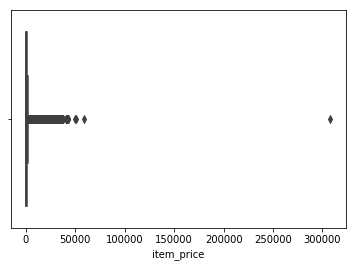

In [28]:
# item_price 외상치 확인
# -1 외에도 외상치가 있을까 
sns.boxplot(train_all.item_price)
#-1 외에 외상치 없는 것으로 판단

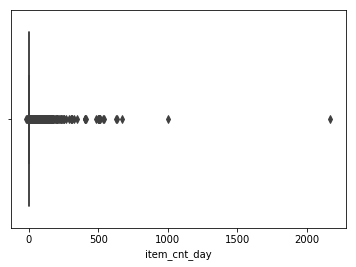

In [29]:
sns.boxplot(train_all.item_cnt_day)

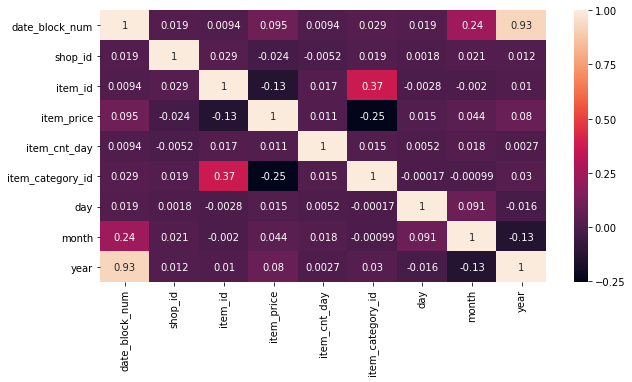

In [30]:
#상관도
train_corr = train_all.corr()
plt.figure(figsize=(10,5))
sns.heatmap(train_corr, annot=True)

==>같은 범주에 속한 컬럼을 제외하고 (date_block_num과 year, month, item_id와 item_category_id 등) 상관성을 거의 띄지 않음

### shop

In [23]:
shop_df['city'] = shop_df['shop_name'].apply(lambda name : name.split(' ')[0])

In [24]:
shop_df['type'] = shop_df['shop_name'].apply(lambda name : name.split('"')[1])

In [25]:
shop_df.head()

,shop_name,shop_id,city,type
0,"!Якутск ТЦ ""Орджоникидзе""56 фран",0,!Якутск,Орджоникидзе
1,"!Якутск ТЦ ""Центральный"" фран",1,!Якутск,Центральный
2,"Адыгея ТЦ ""Мега""",2,Адыгея,Мега
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха,Октябрь-Киномир
4,"Волжский ТЦ ""Волга Молл""",4,Волжский,Волга Молл


In [26]:
train_all = pd.merge(train_df, item_df, how='left', on=['item_id','item_id'])
train_all = pd.merge(train_all, item_category_df, how='left', on=['item_category_id','item_category_id'])
train_all = pd.merge(train_all, shop_df, how='left', on=['shop_id','shop_id'])

In [52]:
shop_df['city'].nunique()

32

#아이디어
도시별로 군집화 후, 라벨링한 열 추가

In [48]:
from sklearn.cluster import KMeans

In [ ]:
#####
# 32개의 city를 숫자로 변환
#####



In [50]:
cluster1 = train_all[['city', 'item_cnt_day']]
kmeans = KMeans(n_clusters=3)
kmeans.fit(cluster1)

ValueError: could not convert string to float: 'Москва'

In [ ]:
kmeans.labels_

In [ ]:
kmeans.cluster_centers_

In [ ]:
model = KMeans(n_clusters=3,algorithm='auto')

model.fit(feature)

predict = pd.DataFrame(model.predict(feature))

predict.columns=['city']

In [ ]:
#####
label을 열로 추가 가능?
#####

In [31]:
city_1 = train_all.groupby('city')['item_cnt_day'].mean()

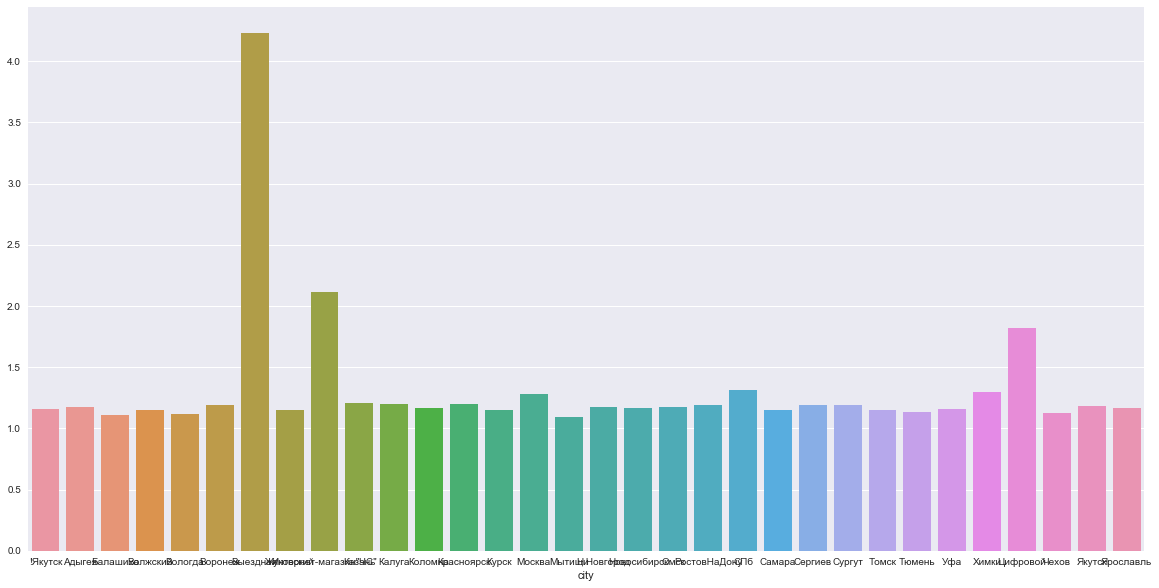

In [40]:
sns.set(rc={'figure.figsize':(20,10)})
sns.barplot(city_1.index, city_1.values)
plt.show()

#아이디어
평균을 내서 그 이상인 그룹, 그 이하인 그룹

In [41]:
type_1 = train_all.groupby('type')['item_cnt_day'].mean()

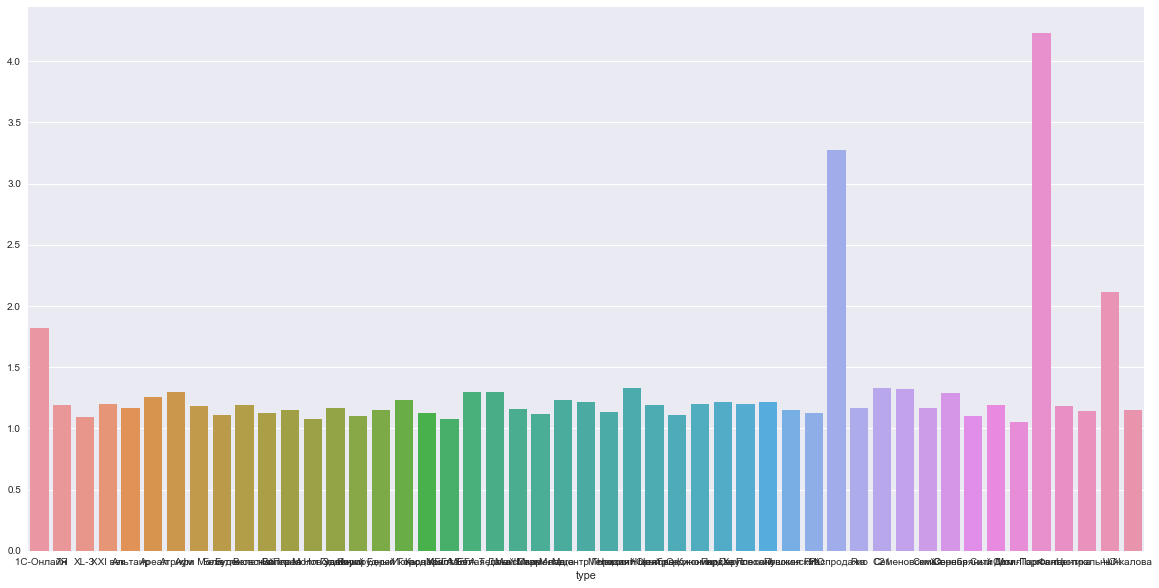

In [42]:
sns.set(rc={'figure.figsize':(20,10)})
sns.barplot(type_1.index, type_1.values)
plt.show()

### Item_category

## 차원축소

In [ ]:
#####
ex_0304예제 참고해서 공부하기
#####

In [31]:
# PCA 예제 코드
from sklearn import preprocessing
from sklearn.decomposition import PCA

In [32]:
# PCA 성분 2개 지정
pca = PCA(n_components=2)
pca.fit_transform(train_all.iloc[:,1:])

array([[-11943.131903  ,    580.99924444],
       [  7639.54557588,   -294.30769086],
       [  7639.54559783,   -294.30758222],
       ...,
       [  2714.63655499,   -649.75613086],
       [  2731.64206989,   -700.47185808],
       [  2711.6596598 ,   -699.67816505]])

In [33]:
# 성분 (누적) 설명력 확인
print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.cumsum())

[0.93173157 0.06825237]
[0.93173157 0.99998394]


In [34]:
# 세부 항목의 Eigenvalue 확인
pd.DataFrame(pca.components_, index=['PC1', 'PC2'], columns=train_all.iloc[:,1:].columns).T

,PC1,PC2
date_block_num,-0.000012,0.000535
shop_id,-0.000076,-0.000189
item_id,-0.999217,0.039555
item_price,0.039553,0.999215
item_cnt_day,-0.000007,0.000021
item_category_id,-0.001004,-0.002016
day,0.000004,0.000075
month,0.000001,0.000091
year,-0.000001,0.000037


# Feature Engineering

## 외상치 제거

In [35]:
# item_price == -1인 행 제거
train_all = train_all.drop([484683,], axis = 0)

## 매장

## 카테고리별

## Mean Encoding

https://www.kaggle.com/iwamoto/predict-future-sales

Aggregate data
Since the competition task is to make a monthly prediction, I need to aggregate the data to montly level before doing any encodings.

In [53]:
from itertools import product

In [84]:
sales = pd.merge(train_df, item_df, on='item_id', how='left')
#sales = sales.drop('item_name', axis=1)
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id
0,02.01.2013,0,59,22154,999.00,1.0,ЯВЛЕНИЕ 2012 (BD),37
1,03.01.2013,0,25,2552,899.00,1.0,DEEP PURPLE The House Of Blue Light LP,58
2,05.01.2013,0,25,2552,899.00,-1.0,DEEP PURPLE The House Of Blue Light LP,58
3,06.01.2013,0,25,2554,1709.05,1.0,DEEP PURPLE Who Do You Think We Are LP,58
4,15.01.2013,0,25,2555,1099.00,1.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56


In [89]:
# For every month we create a grid from all shops/items combinations from that month
grid = []
for blockNum in train_all.date_block_num.unique():
    shopIds = sales.loc[sales.date_block_num == blockNum, 'shop_id'].unique()
    itemIds = sales.loc[sales.date_block_num == blockNum, 'item_id'].unique()
    grid.append(np.array(list(product(*[[blockNum], shopIds, itemIds])), dtype='int32'))
grid = pd.DataFrame(np.vstack(grid), columns=['date_block_num', 'shop_id', 'item_id'], dtype='int32')

#For every month we create a grid from all shops/items combinations from that month
grid = []
for blockNum in sales.date_block_num.unique():
    shopIds = sales.loc[sales.date_block_num == blockNum, 'shop_id'].unique()
    itemIds = sales.loc[sales.date_block_num == blockNum, 'item_id'].unique()
    grid.append(np.array(list(product(*[[blockNum], shopIds, itemIds])), dtype='int32'))
grid = pd.DataFrame(np.vstack(grid), columns=['date_block_num', 'shop_id', 'item_id'], dtype='int32')

In [83]:
grid.head()

,date_block_num,shop_id,item_id
0,0,59,22154
1,0,59,2552
2,0,59,2554
3,0,59,2555
4,0,59,2564


In [90]:
salesMean = train_all.groupby(['date_block_num', 'shop_id', 'item_id']).agg({'item_cnt_day': 'sum', 'item_price':'mean'}).reset_index()
salesMean = pd.merge(grid, train_all, how='left', on=['date_block_num', 'shop_id', 'item_id']).fillna(0)
salesMean = pd.merge(train_all, item_df, how='left', on=['item_id'])

In [91]:
salesMean.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name_x,item_category_id_x,item_category_name,shop_name,city,type,item_name_y,item_category_id_y
0,02.01.2013,0,59,22154,999.00,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир""",Ярославль,Альтаир,ЯВЛЕНИЕ 2012 (BD),37
1,03.01.2013,0,25,2552,899.00,1.0,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,"Москва ТРК ""Атриум""",Москва,Атриум,DEEP PURPLE The House Of Blue Light LP,58
2,05.01.2013,0,25,2552,899.00,-1.0,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,"Москва ТРК ""Атриум""",Москва,Атриум,DEEP PURPLE The House Of Blue Light LP,58
3,06.01.2013,0,25,2554,1709.05,1.0,DEEP PURPLE Who Do You Think We Are LP,58,Музыка - Винил,"Москва ТРК ""Атриум""",Москва,Атриум,DEEP PURPLE Who Do You Think We Are LP,58
4,15.01.2013,0,25,2555,1099.00,1.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Музыка - CD фирменного производства,"Москва ТРК ""Атриум""",Москва,Атриум,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56


In [92]:
salesMean.drop(['item_name_y', 'item_category_id_y'], axis=1, inplace=True)

In [93]:
salesMean.columns = ['date','date_block_num', 'shop_id', 'item_id', 'item_price', 'item_cnt_day', 'item_name', 'item_category_id', 'item_category_name','shop_name','city','type']

#Get aggregated values for (shop_id, item_id, month)
#The count and average price of sold items in each shop for a month
salesMean = train_all.groupby(['date_block_num', 'shop_id', 'item_id']).agg({'item_cnt_day': 'sum', 'item_price':'mean'}).reset_index()
salesMean = pd.merge(grid, train_all, how='left', on=['date_block_num', 'shop_id', 'item_id']).fillna(0)
salesMean = pd.merge(train_all, item_df, how='left', on=['item_id'])
salesMean.columns = ['date_block_num_mean', 'shop_id_mean', 'item_id_mean', 'shop_item_count_sum', 'shop_item_price_mean', 'item_name', 'item_category_id_mean']
#salesMean.drop(['item_name'], axis=1, inplace=True)
salesMean.shop_item_count_sum = salesMean.shop_item_count_sum.astype('int32')

salesMean.head(10).T

Mean Encodings
Shop, item and category ID are encoded in 3 ways:

Average price
Average count of sold items
Total count of sold items

def encodeMean(groupColumns, tarnsformColumn, outputColumn):
    gb = salesMean.groupby(groupColumns)
    salesMean[outputColumn + '_mean'] = gb[tarnsformColumn].transform('mean').astype('float32')

def encodeMeanSum(groupColumns, tarnsformColumn, outputColumn):
    gb = salesMean.groupby(groupColumns)
    salesMean[outputColumn + '_mean'] = gb[tarnsformColumn].transform('mean').astype('float32')
    salesMean[outputColumn + '_sum'] = gb[tarnsformColumn].transform('sum').astype('float32')

encodeMean   (['date_block_num_mean', 'shop_id_mean'],          'shop_item_price_mean', 'shop_price')
encodeMeanSum(['date_block_num_mean', 'shop_id_mean'],          'shop_item_count_sum',  'shop_count')

encodeMean   (['date_block_num_mean', 'item_id_mean'],          'shop_item_price_mean', 'item_price')
encodeMeanSum(['date_block_num_mean', 'item_id_mean'],          'shop_item_count_sum',  'item_count')

encodeMean   (['date_block_num_mean', 'item_category_id_mean'], 'shop_item_price_mean', 'category_price')
encodeMeanSum(['date_block_num_mean', 'item_category_id_mean'], 'shop_item_count_sum',  'category_count')

salesMean.head(10).T

In [95]:
def encodeMean(groupColumns, tarnsformColumn, outputColumn):
    gb = salesMean.groupby(groupColumns)
    salesMean[outputColumn + '_mean'] = gb[tarnsformColumn].transform('mean').astype('float32')

def encodeMeanSum(groupColumns, tarnsformColumn, outputColumn):
    gb = salesMean.groupby(groupColumns)
    salesMean[outputColumn + '_mean'] = gb[tarnsformColumn].transform('mean').astype('float32')
    salesMean[outputColumn + '_sum'] = gb[tarnsformColumn].transform('sum').astype('float32')

encodeMean   (['date_block_num', 'shop_id'],          'shop_item_price_mean', 'shop_price')
encodeMeanSum(['date_block_num', 'shop_id'],          'shop_item_count_sum',  'shop_count')

encodeMean   (['date_block_num', 'item_id'],          'shop_item_price_mean', 'item_price')
encodeMeanSum(['date_block_num', 'item_id'],          'shop_item_count_sum',  'item_count')

encodeMean   (['date_block_num', 'item_category_id'], 'shop_item_price_mean', 'category_price')
encodeMeanSum(['date_block_num', 'item_category_id'], 'shop_item_count_sum',  'category_count')

salesMean.head(10).T

KeyError: 'Column not found: shop_item_price_mean'

In [79]:
print(salesMean.shape)
print(train_all.shape)

(10913850, 16)
(2935849, 12)


### mean encoding 결과와 train_all합치기

In [88]:
train_mean = pd.merge(train_all,salesMean, how='left', on='item_name')

MemoryError: 

# Modeling

- Preprocessing: minmax scale
- Feature Selection: SelectKBest()
- Model fit with Logistic Regression
- Testing: Confusion Matrix

In [42]:
from sklearn.model_selection import train_test_split

In [43]:
X = train_all.drop(columns=['date','item_cnt_day','day'])
y = train_all.item_cnt_day

# 테스트셋 분리
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size =0.3, random_state = 1234)
print("\ntrain.shape   test.shape")
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)


train.shape   test.shape
(2055093, 7) (880755, 7) (2055093,) (880755,)


## 선형회귀

In [49]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn import metrics

In [50]:
lm=LinearRegression()
lm.fit(X_train,y_train)
rsq_lm = lm.score(X_test,y_test)
mae_lm = mean_absolute_error(y_test, lm.predict(X_test))
mse_lm = mean_squared_error(y_test, lm.predict(X_test))
rmse_lm = np.sqrt(metrics.mean_squared_error(y_test, lm.predict(X_test)))

print(f"R^2 : {rsq_lm}")
print(f"MAE : {mae_lm}")
print(f"MSE : {mse_lm}")
print(f"RMSE : {rmse_lm}")

R^2 : 0.0012435152701806285
MAE : 0.44215954189458795
MSE : 5.126997022535969
RMSE : 2.2642873100682186


In [51]:
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
X = min_max_scaler.fit_transform(X)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 1234)

lm=LinearRegression()
lm.fit(X_train,y_train)
rsq_lm = lm.score(X_test,y_test)
mae_lm = mean_absolute_error(y_test, lm.predict(X_test))
mse_lm = mean_squared_error(y_test, lm.predict(X_test))
rmse_lm = np.sqrt(metrics.mean_squared_error(y_test, lm.predict(X_test)))

print(f"R^2 : {rsq_lm}")
print(f"MAE : {mae_lm}")
print(f"MSE : {mse_lm}")
print(f"RMSE : {rmse_lm}")

R^2 : 0.0012435141706383934
MAE : 0.4421599943188288
MSE : 5.126997028180337
RMSE : 2.2642873113146083


==> MinMaxScaler는 큰 차이 없음

## 의사결정나무

In [52]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

In [53]:
rsq_tree_reg = tree_reg.score(X_test,y_test)
mae_tree_reg = mean_absolute_error(y_test, tree_reg.predict(X_test))
mse_tree_reg = mean_squared_error(y_test, tree_reg.predict(X_test))
rmse_tree_reg = np.sqrt(metrics.mean_squared_error(y_test, tree_reg.predict(X_test)))

print(f"R^2 : {rsq_tree_reg}")
print(f"MAE : {mae_tree_reg}")
print(f"MSE : {mse_tree_reg}")
print(f"RMSE : {rmse_tree_reg}")

R^2 : -0.012394043741238647
MAE : 0.2943914385228589
MSE : 5.197003801480808
RMSE : 2.2796937955525536


## 랜덤포레스트

In [54]:
from sklearn.ensemble import RandomForestRegressor

In [55]:
forest_reg = RandomForestRegressor(random_state=42)
forest_reg.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [56]:
rsq_forest_reg = forest_reg.score(X_test,y_test)
mae_forest_reg = mean_absolute_error(y_test, forest_reg.predict(X_test))
mse_forest_reg = mean_squared_error(y_test, forest_reg.predict(X_test))
rmse_forest_reg = np.sqrt(metrics.mean_squared_error(y_test, forest_reg.predict(X_test)))

print(f"R^2 : {rsq_forest_reg}")
print(f"MAE : {mae_forest_reg}")
print(f"MSE : {mse_forest_reg}")
print(f"RMSE : {rmse_forest_reg}")

R^2 : 0.13074580429287275
MAE : 0.2916463777547251
MSE : 4.462212502603118
RMSE : 2.1123949684192866


In [58]:
from sklearn.model_selection import GridSearchCV

In [68]:
param_grid = [
        {'n_estimators': [3, 10, 30], 'random_state': [42]},
        {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4], 'random_state': [42]},
    ]

 Invalid parameter n_features for estimator RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=3, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False). Check the list of available parameters with `estimator.get_params().keys()`.

In [70]:
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
param_grid

In [ ]:
grid_search.best_params_

In [ ]:
forestbest_reg = grid_search.best_estimator_
forestbest_reg

In [ ]:
forestbest_reg.fit(X_train, y_train)

In [ ]:
forestbest_reg.fit(X_train, y_train)
rsq_forestbest_reg = forestbest_reg.score(X_test,y_test)
mae_forestbest_reg = mean_absolute_error(y_test, forestbest_reg.predict(X_test))
mse_forestbest_reg = mean_squared_error(y_test, forestbest_reg.predict(X_test))
rmse_forestbest_reg = np.sqrt(metrics.mean_squared_error(y_test, forestbest_reg.predict(X_test)))

print(f"R^2 : {rsq_forestbest_reg}")
print(f"MAE : {mae_forestbest_reg}")
print(f"MSE : {mse_forestbest_reg}")
print(f"RMSE : {rmse_forestbest_reg}")

## Gradient boosting 

In [ ]:
from sklearn.ensenble import GradientBoostingRegressor

## XGboost

In [71]:
from xgboost import XGBRegressor
from xgboost import plot_importance
import xgboost as xgb

In [ ]:
param = {'max_depth':10, 
         'subsample':1,
         'min_child_weight':0.5,
         'eta':0.3, 
         'num_round':1000, 
         'seed':1,
         'silent':0,
         'eval_metric':'rmse'}

# param = {
#      'max_depth'=8,
#     'n_estimators'=1000,
#     'min_child_weight'=300, 
#     'colsample_bytree'=0.8, 
#     'subsample'=0.8, 
#     'eta'=0.3,    
#     'seed'=42
# }

progress = dict()
xgbtrain = xgb.DMatrix(train_cleaned_df.iloc[:,  (train_cleaned_df.columns != 33)].values, train_cleaned_df.iloc[:, train_cleaned_df.columns == 33].values)
watchlist  = [(xgbtrain,'train-rmse')]

bst = xgb.train(param, xgbtrain)
preds = bst.predict(xgb.DMatrix(train_cleaned_df.iloc[:,  (train_cleaned_df.columns != 33)].values))
from sklearn.metrics import mean_squared_error 
rmse = np.sqrt(mean_squared_error(preds,train_cleaned_df.iloc[:, train_cleaned_df.columns == 33].values))

In [ ]:
X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [73]:
xgb_reg = XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=42)

xgb_reg.fit(
    X_train, 
    y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, y_train), (X_test, y_test)], 
    verbose=True, 
    early_stopping_rounds = 10)

[0]	validation_0-rmse:2.81288	validation_1-rmse:2.33445
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:2.77812	validation_1-rmse:2.29338
[2]	validation_0-rmse:2.75504	validation_1-rmse:2.26653
[3]	validation_0-rmse:2.7326	validation_1-rmse:2.24035
[4]	validation_0-rmse:2.71534	validation_1-rmse:2.22083
[5]	validation_0-rmse:2.69762	validation_1-rmse:2.20018
[6]	validation_0-rmse:2.68195	validation_1-rmse:2.18288
[7]	validation_0-rmse:2.66742	validation_1-rmse:2.16692
[8]	validation_0-rmse:2.65737	validation_1-rmse:2.15564
[9]	validation_0-rmse:2.64753	validation_1-rmse:2.14494
[10]	validation_0-rmse:2.63846	validation_1-rmse:2.13489
[11]	validation_0-rmse:2.63178	validation_1-rmse:2.12795
[12]	validation_0-rmse:2.62653	validation_1-rmse:2.12203
[13]	validation_0-rmse:2.62202	validation_1-rmse:2.11738
[14]	validation_0-rmse:2.61871	validation_1-rmse:2.113

[141]	validation_0-rmse:2.53274	validation_1-rmse:2.05038
[142]	validation_0-rmse:2.5325	validation_1-rmse:2.05035
[143]	validation_0-rmse:2.53213	validation_1-rmse:2.05012
[144]	validation_0-rmse:2.53146	validation_1-rmse:2.04998
[145]	validation_0-rmse:2.53123	validation_1-rmse:2.0496
[146]	validation_0-rmse:2.53084	validation_1-rmse:2.04953
[147]	validation_0-rmse:2.53063	validation_1-rmse:2.04949
[148]	validation_0-rmse:2.5304	validation_1-rmse:2.04941
[149]	validation_0-rmse:2.53019	validation_1-rmse:2.04929
[150]	validation_0-rmse:2.52979	validation_1-rmse:2.04919
[151]	validation_0-rmse:2.52974	validation_1-rmse:2.049
[152]	validation_0-rmse:2.52948	validation_1-rmse:2.04886
[153]	validation_0-rmse:2.52883	validation_1-rmse:2.04854
[154]	validation_0-rmse:2.52845	validation_1-rmse:2.04841
[155]	validation_0-rmse:2.52844	validation_1-rmse:2.04817
[156]	validation_0-rmse:2.52818	validation_1-rmse:2.04813
[157]	validation_0-rmse:2.52792	validation_1-rmse:2.04808
[158]	validation_0-

[283]	validation_0-rmse:2.49109	validation_1-rmse:2.03588
[284]	validation_0-rmse:2.491	validation_1-rmse:2.03576
[285]	validation_0-rmse:2.49065	validation_1-rmse:2.03539
[286]	validation_0-rmse:2.49051	validation_1-rmse:2.03513
[287]	validation_0-rmse:2.49031	validation_1-rmse:2.03517
[288]	validation_0-rmse:2.49011	validation_1-rmse:2.03502
[289]	validation_0-rmse:2.48979	validation_1-rmse:2.03498
[290]	validation_0-rmse:2.48936	validation_1-rmse:2.0351
[291]	validation_0-rmse:2.48907	validation_1-rmse:2.03504
[292]	validation_0-rmse:2.48856	validation_1-rmse:2.03507
[293]	validation_0-rmse:2.48833	validation_1-rmse:2.03505
[294]	validation_0-rmse:2.48822	validation_1-rmse:2.03483
[295]	validation_0-rmse:2.48775	validation_1-rmse:2.03446
[296]	validation_0-rmse:2.48736	validation_1-rmse:2.03439
[297]	validation_0-rmse:2.48715	validation_1-rmse:2.03441
[298]	validation_0-rmse:2.48694	validation_1-rmse:2.03431
[299]	validation_0-rmse:2.48646	validation_1-rmse:2.03415
[300]	validation_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, eta=0.3, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=8,
       min_child_weight=300, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=42, silent=True,
       subsample=0.8)

In [ ]:
Y_pred = model.predict(X_valid).clip(0, 20)
Y_test = model.predict(X_test).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('xgb_submission.csv', index=False)